# Tarea académica del curso Inteligencia Artificial Aplicada


profesor: Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

Grupo 2

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para usar solo la memória de la GPU necesária en tiempo de ejecucion
    tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus)

[]


In [2]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense

from keras.models import Model
from keras.layers import Input, BatchNormalization
from keras.layers import concatenate, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, AdamW

from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# Proyecto de Construcción de Modelos ANN con series Multivariadas y pronóstico Multi-step

El proyecto consta de realizar las pruebas de modelos ANN para predecir la morosidad del siguiente mes que tendrá el área de microempresas en cajas municipales. Para el proyecto solo se tiene en cuenta la CMCP Lima, sin embargo el código está automatizado para poder elegir entre 8 cajas: CMAC Arequipa, CMAC Huancayo, CMAC Tacna, CMAC Ica, CMAC Piura, CMAC Sullana, CMAC Trujillo y CMCP Lima. La hipótesis es que con la información de bases de datos abiertos de la INEI sobre la tasa de morosidad mensual, es posible crear un modelo que prediga la morosidad del siguiente mes. El objetivo es poder prevenir a las cajas municipales de la morosidad que presumiblemente tendrán para que puedan aplicar medidas económicas adecuadas. El dataset final se consigue con el archivo "Pre-procesamiento.py" y consta de 1127 registros y las siguintes variables:


    1.Fecha (index)
    2.Miembros con ingresos: Número promedio de personas con posibles ingresos económicos en el hogar
    3.Total perceptores: Número total de perceptores efectivos (trabajan o reciben ingreso) en el hogar
    4.Gasto en alquiler: Monto de pago mensual en vivienda
    5.Ingreso bruto del hogar: Ingreso total del hogar
    6.Ingreso independiente: Ingreso proveniente de trabajos autónomos o informales
    7.Gasto en servicios públicos: Gasto mensual del hogar en servicios como luz, agua, gas, telefonía.
    8.Ingreso por becas educativas (1): Subvenciones o transferencias ingresadas por educación
    9.Hogares pobres: Promedio de clasificacion de hogares considerados en situación de pobreza monetaria
    10.Caja municipal: Entidad financiera específica
    11.Tasa de morosidad (%): Porcentaje de créditos vencidos o impagos en la caja municipal correspondiente por microempresas.



### Carga y Pre-procesamiento de  datos

In [3]:
# carga el dataset pre-procesado
df = pd.read_csv('df_modelo_final',index_col = "Fecha")
df.head()

,Miembros con ingreso,Total perceptores,Gasto en alquiler,Ingreso bruto del hogar,Ingreso independiente,Gasto en servicios públicos,Ingreso por becas educativas (1),Hogares pobres,Caja Municipal,Tasa de morosidad (%)
Fecha,,,,,,,,,,
2009-05-01,4.140760,2.212231,190.864362,8584.348585,6653.652671,621.433130,260.243621,2.590945,CMAC Arequipa,5.077602
2009-06-01,4.142531,2.189882,187.355031,9365.305438,6464.000656,672.123398,439.862814,2.641171,CMAC Arequipa,5.051471
2009-07-01,4.197993,2.200152,190.979926,9314.389936,5655.809153,782.439024,409.412184,2.635976,CMAC Arequipa,5.206253
2009-08-01,4.079351,2.221466,162.573153,7445.068070,6796.224960,591.096240,486.747522,2.625111,CMAC Arequipa,5.353463
2009-09-01,4.130958,2.197218,245.831508,10285.387360,5911.574302,690.846980,390.656224,2.625901,CMAC Arequipa,5.009459


Se elige cuál caja se desea utilizar. En este caso se utiliza la CMCP Lima

In [4]:
dfs = {caja: grupo.copy() for caja, grupo in df.groupby('Caja Municipal')}
df_Lima = dfs["CMCP Lima"]

In [5]:
df_Lima = df_Lima.drop(columns=['Caja Municipal'])
df_Lima.head()

,Miembros con ingreso,Total perceptores,Gasto en alquiler,Ingreso bruto del hogar,Ingreso independiente,Gasto en servicios públicos,Ingreso por becas educativas (1),Hogares pobres,Tasa de morosidad (%)
Fecha,,,,,,,,,
2009-05-01,3.917014,2.306394,463.866675,13780.553406,11611.955525,612.991689,208.047464,2.836617,4.561231
2009-06-01,3.966028,2.328828,603.716850,18579.015738,8068.838624,685.652568,1062.195641,2.826342,4.457446
2009-07-01,3.842842,2.242699,460.387124,14597.392448,5125.937626,964.162733,998.989439,2.878284,4.284711
2009-08-01,3.812811,2.254040,562.345697,12934.001643,9278.168706,569.507993,477.285049,2.855081,4.010911
2009-09-01,3.877955,2.328492,863.461875,22360.036169,7538.304042,1294.833359,462.767000,2.917486,3.811757


In [6]:
df_Lima.describe()

,Miembros con ingreso,Total perceptores,Gasto en alquiler,Ingreso bruto del hogar,Ingreso independiente,Gasto en servicios públicos,Ingreso por becas educativas (1),Hogares pobres,Tasa de morosidad (%)
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,3.599148,2.193036,1014.168135,21169.194288,9515.166147,959.243795,491.341022,2.833303,11.791064
std,0.259376,0.120489,428.965304,3196.967349,2146.310776,219.976736,292.201829,0.154983,5.783579
min,3.010976,1.881542,377.257100,12934.001643,5125.937626,498.558850,68.373972,2.239813,2.233616
25%,3.431126,2.113520,698.621592,18872.071591,8315.832112,801.093174,310.700946,2.828585,7.470990
50%,3.623948,2.190517,951.363588,21302.625018,9197.609354,949.845220,434.169787,2.881645,11.029428
75%,3.771146,2.293729,1254.754698,23088.484427,10201.838020,1085.863905,582.712547,2.916658,15.168742
max,4.296152,2.468842,2422.904849,30092.706500,23943.369263,1493.359420,2512.234249,2.968071,26.751936


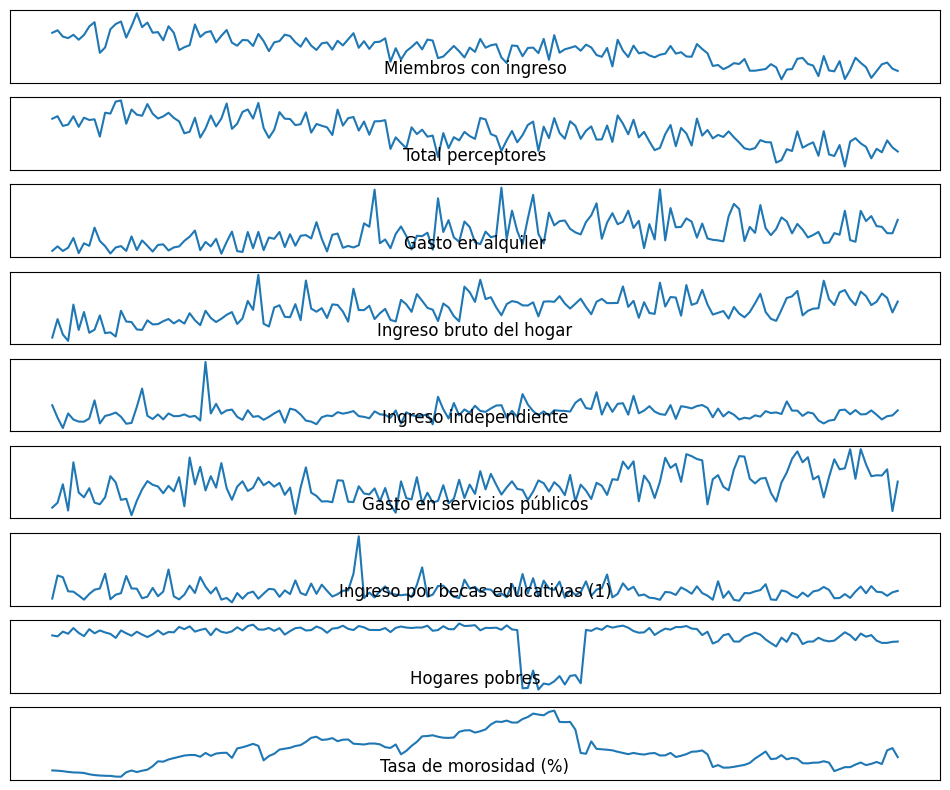

In [7]:
# Visualiza las series diarias con Line plots
plt.rcParams['figure.figsize'] = [12, 10]  #por defecto las figuras se displayan 8 pulgadas de ancho y 6 de alto
for i in range(len(df_Lima.columns)):
    # crea subplots
    plt.subplot(len(df_Lima.columns), 1, i+1)
    # obtiene nombre de variable
    name = df_Lima.columns[i]
    # plotea data
    plt.plot(df_Lima[name])
    # colca titulo
    plt.title(name, y=0)
    # deshabilita ticks
    plt.yticks([])
    plt.xticks([])
plt.show()

Tras un último análisis gráfico, se decide eliminar la variable "Total perceptores" por contener información muy similar a "Ingreso bruto del hogar" y también se elimina "Hogares pobres" por su inconsistencia generada en el ao 2017 por el cálculo manual realizado en la etapa de pre-procesamiento.

In [8]:
df_Lima = df_Lima.drop(columns=['Total perceptores','Hogares pobres'])

## Modelos de Persistencia

#### Define Modelo de Persistencia Mensual
Este modelo toma el ultimo valor observado  como el valor predicho de cada dia de los siguientes steps_out valores

In [9]:
# Modelo de persistencia de ultimo valor para forecasting multistep univariado con steps_out pasos de pronnostico
def lastvalue_persistence(history, steps_out):
    # obtiene data del ultimo dia
    last_value = history[-1]
    # el forecast es una lista de steps_out valores iguales al ultimo valor de history
    forecast = [last_value for _ in range(steps_out)]
    return forecast

#### Define Modelo de Persistencia Trimestral
Este modelo toma los valores del trimestre anterior como los valores a predecir

In [10]:
# Modelo de persistencia que replica ultimos n_steps_out valores para forecasting multistep univariado con n_steps_out pasos de pronnostico
def lastwindow_persistence(history, steps_out):
    # Obtiene datos de los ultimos steps_out dias
    forecast = history[-steps_out:]
    return forecast  # el forecast es igual a los ultimos steps_out valores de history

### Definiendo la metrica de evaluación
La predicción que deben realizar los modelos es de 3 meses (3 puntos temporales). La evaluación de la precisión de la prediccion se hará separadamente para cada mes predicho a fin de conocer el comportamiento del desempeño del modelo a diferentes horizontes temporales. Como metrica de desempeño se usará el RMSE, MAE y MSE. La siguiente función obtiene dicha métrica por mes  y una medida general de toda la prediccion   

In [11]:
# Evalua RMSE de predicciones de forecasting multistep con respecto a valores reales.
# 'predicted' es un numpy array con cada fila siendo una prediccion forecast multistep. Cada columna es un timestep adelante
# 'real' es un numpy array con cada fila i siendo los valores futuros verdaderos para comparar con la fila i de 'forecast'
def evaluate_forecasts(real, predicted):
    scores = list()
    # Para cada timestep t ahead calcula el RMSE
    for t in range(real.shape[1]):
        # calcula rmse
        rmse = sqrt( mean_squared_error(real[:, t], predicted[:, t]))
        # guarda rmse de este dia
        scores.append(rmse)

    # calcula RMSE global
    s = 0
    for row in range(real.shape[0]):  # por cada vector pronosticado
        for col in range(real.shape[1]): # por cada time step
            s += (real[row, col] - predicted[row, col])**2
    score = sqrt(s / (real.shape[0] * real.shape[1]))
    
    return score, scores

#### Funcion para evaluar  modelos de persistencia en Walk-Forward
Los modelos seran evaluados en estrategia walk-forward en datos de test. La prediccion es hecha a nivel de anual, es decir se toma el historico de años previos para predecir los meses del año siguiente  


In [ ]:
# evalua en walk-forward un modelo de forecasting multistep pasado (model_func) en su capacidad de predecir steps_out futuros,
# se le pasa la serie completa y la cantidad de los ultimos time_points que se usaran para test (test_size)
def evaluate_model(model_func, serie, test_size, steps_out):
    # split la serie en train - test
    train_serie, test_serie = serie[0:-test_size], serie[-test_size:]

    # validacion walk-forward de modelo de persistencia
    history = train_serie.tolist()  # serie historica para el modelado. Inicialmente es train

    # walk-forward validation sobre cada semana
    predictions = list()  # array donde se almacenan los vectores de prediccion multistep
    real = list()  # array donde se almacenan los vectores reales para comparar con las predicciones multistep
    for i in range(len(test_serie)-steps_out+1): # recorre cada time step de test
        # predice steps_out valores. model_func  se encarga de entrenar y hacer la prediccion
        yhat_sequence = model_func(history, steps_out)
        # almacena la secuencia predicha
        predictions.append(yhat_sequence)

        # adiciona al array real la secuencia que debio salir
        real.append(test_serie[i:i+steps_out])

        # añade la observacion real a history para la siguiente iteracion
        history.append(test_serie[i])
    predictions = np.array(predictions)
    real = np.array(real)
    # evalua las secuencias predichas en test con respecto a lo que debio salir
    score, scores = evaluate_forecasts(real, predictions)
    return score, scores

#### Evalua Modelos de Persistencia en Walk-Forward

RMSE de monthly_persistence: 1.902 
RMSE de yearly_persistence: 1.997 


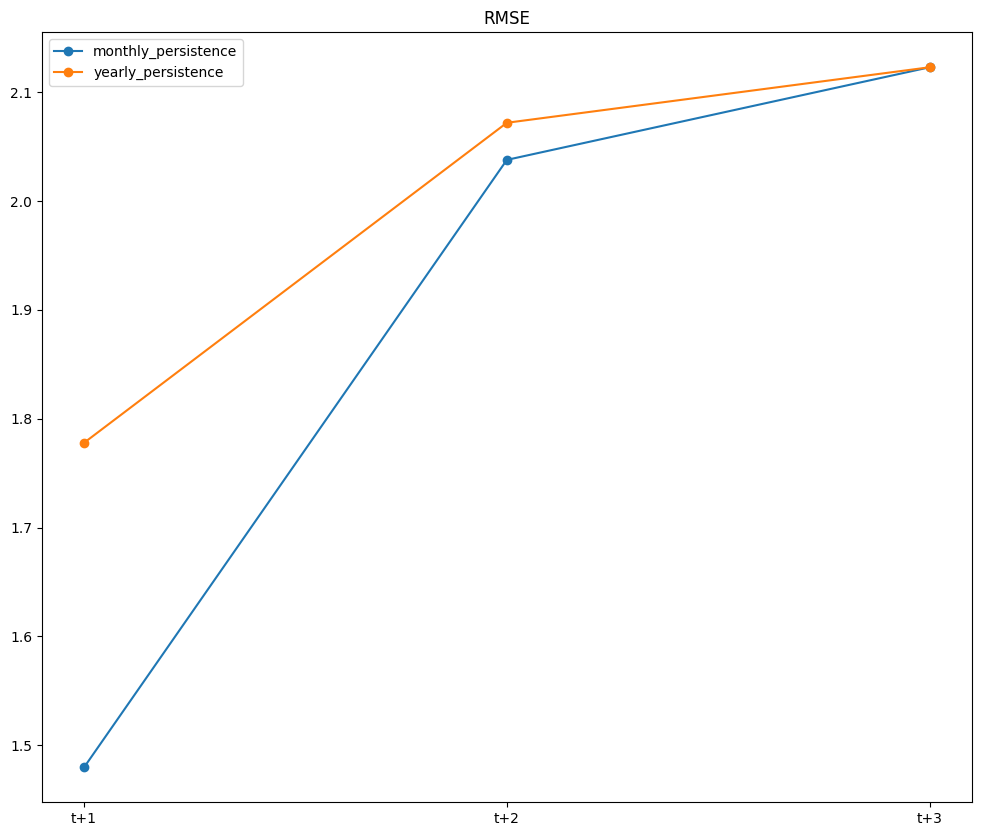

In [ ]:
models = dict()
models['monthly_persistence'] = lastvalue_persistence
models['yearly_persistence'] = lastwindow_persistence
time_labels = ['t+1', 't+2', 't+3']
test_size = 24  # los puntos de los ultimos dos años sera usadas para prueba, los cuales son 24 meses
steps_out = 3  # los modelos predicen 3 puntos temporales futuros

# evalua cada  model de persistencia en su performance de pronosticar 3 meses de la serie 'Tasa de morosidad (%)'
for name, model_func in models.items():
    # evalua modelos y obtiene scores
    score, scores = evaluate_model(model_func, df_Lima['Tasa de morosidad (%)'].values, test_size, steps_out)
    # imprime score global
    print('RMSE de %s: %.3f ' % (name, score))
    # plotea scores
    plt.plot(time_labels, scores, marker='o', label=name)

# show plot
plt.title('RMSE')
plt.legend()
plt.show()

## Modelo ANN Univariado Multi-step

Aqui se evaluará un modelo de forecasting univariado multistep de tipo ANN. Este tendrá la capacidad de predecir los siguientes **steps_out** valores de porcentajes de tasa de morosidad (Tasa de morosidad (%)) en base a los ultimos **steps_in** valores previos.
Para comparar con los resultados de los modelos de persistencia usaremos los 3 ultimos puntos temporales para prueba.

### Funcion para generar muestras de entrenamiento para forecasting univariado multistep

La funcion <b>split_sequence()</b> genera tuplas de secuencias de entrenamiento a partir de una serie univariada pasada. Esta desliza una ventana de n_step_in puntos temporales de ancho sobre la serie dada (sequence), generando las secuencias de entrada (inputs de la red) junto con la secuencia target que son los siguientes n_steps_out puntos de la misma secuencia.

 Aqui una muestra de cómo se genera los ejemplos:

    Input (X),                            Target (y)
    [d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14]
    [d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15] ...

In [14]:
# Funcion para generar secuencias de steps_in de entrada y steps_out de target a partir de una secuencia univariada
def split_sequence(sequence, steps_in, steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # calcula el indice del final de la secuencia
        end_ix = i + steps_in  # final de la muestra de entra
        out_end_ix = end_ix + steps_out  # final de la muestra de salida

        # si el indice es mayor que la secuencia entonces deja de generar mas muestras
        if out_end_ix > len(sequence)-1:
            break

        X.append( sequence[i:end_ix] ) # añade la secuencia a la lista de muestras de entrada para entrenamiento
        y.append( sequence[end_ix:out_end_ix] )   # añade los siguientes  steps_out puntos como target
    return np.array(X), np.array(y)

Probemos la funcion *split_sequence()* sobre toda la serie de Tasa de morosidad (%)

In [ ]:
steps_in = 12
steps_out = 3

# genera las muestras de entrenamiento en rolling window a partir de la serie de entrenamiento
X, y = split_sequence(df_Lima['Tasa de morosidad (%)'].values, steps_in, steps_out)
print (X.shape)

# displaya 5 ejemplos de la data
for i in range(5):
    print(X[i], y[i])

(146, 12)
[4.56123129 4.45744594 4.28471118 4.01091092 3.81175693 3.76703875
 3.60988485 3.13226743 2.83580114 2.67181408 2.56886206 2.53384793] [2.28285737 2.2336156  3.89046206]
[4.45744594 4.28471118 4.01091092 3.81175693 3.76703875 3.60988485
 3.13226743 2.83580114 2.67181408 2.56886206 2.53384793 2.28285737] [2.2336156  3.89046206 4.52851307]
[4.28471118 4.01091092 3.81175693 3.76703875 3.60988485 3.13226743
 2.83580114 2.67181408 2.56886206 2.53384793 2.28285737 2.2336156 ] [3.89046206 4.52851307 3.96421276]
[4.01091092 3.81175693 3.76703875 3.60988485 3.13226743 2.83580114
 2.67181408 2.56886206 2.53384793 2.28285737 2.2336156  3.89046206] [4.52851307 3.96421276 4.45637758]
[3.81175693 3.76703875 3.60988485 3.13226743 2.83580114 2.67181408
 2.56886206 2.53384793 2.28285737 2.2336156  3.89046206 4.52851307] [3.96421276 4.45637758 4.83457417]


### Funciones para entrenamiento y prediccion de un modelo ANN para forecasting univariado multistep

A seguir se muestra una funcion para definir y entrenar un modelo ANN de pronóstico univariado multi-step. Los hiperaparámetros del modelo son pasados en el argumento 'config' y son: cantidad de timesteps de entrada, cantidad de timesteps de forecast, cantidad de filtros convolucionales, el tamaño del filtro, el numero de epocas de entrenamiento y el tamaño del minibatch de entrenamiento

In [16]:
# Funcion para entrenar el modelo ANN para forecasting univariado multistep
def univar_multistep_ANN_fit(train_serie, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config
    
    # genera las muestras de entrenamiento en rolling window a partir de la serie pasada
    X, y = split_sequence(train_serie, steps_in, steps_out)

    modelo = Sequential()
    modelo.add(Dense(n_neurons,activation='relu', input_dim=steps_in))
    modelo.add(BatchNormalization())
    modelo.add(Dropout(0.3))
    modelo.add(Dense(int(n_neurons/2),activation='relu'))

    
    modelo.add(Dropout(0.3))
    modelo.add(Dense(steps_out)) 

    modelo.compile(loss='mse', optimizer="adam", metrics=['mae'])
    early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, verbose = 1)
    #reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

    # entrena el modelo con la la data de entrenamiento generada
    modelo.fit(X, y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[early_stop])
    return modelo

La funcion <b>univar_multistep_ANN_predict</b> hace el forecasting con un modelo ANN ya ajustado y en base a la serie histórica

In [17]:
# predice steps_out valores siguientes de la serie history con un modelo ANN ya ajustado
def univar_multistep_ANN_predict(modelo, history_serie, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # prepara la muestra a ingresar al modelo para hacer la prediccion (los ultimos n_steps_in puntos temporales)
    X_input = np.array(history_serie[-steps_in:]).reshape(1, steps_in)

    # predice
    yhat = modelo.predict(X_input, verbose=0)
    return yhat[0]

La funcion **evaluate_univar_multistep_ANN** hace la evaluacion en walk-forward un modelo ANN para forecasting univariado multistep

In [18]:
# evalua el modelo ANN univariado multi-step  en walk-forward
def evaluate_univar_multistep_ANN(serie, test_size, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # split la serie en train - test
    train_serie, test_serie = serie[0:-test_size], serie[-test_size:]

    # Entrena un modelo MLP para evaluar en walk-forward (solo se entrena una vez)
    modelo = univar_multistep_ANN_fit(train_serie, config)
    modelo.save('ANN_uni.keras')

    # Inicializa la serie historica con la serie de training para empezar la evaluacion en walk-forward
    history = train_serie.tolist()

    # walk-forward validation sobre cada semana
    predictions = list()  # array donde se almacenan los vectores de prediccion multistep
    real = list()  # array donde se almacenan los vectores reales para comparar con las predicciones multistep
    for i in range(len(test_serie)-steps_out+1): # recorre cada time step de test
        # predice  con el modelo
        yhat_sequence = univar_multistep_ANN_predict(modelo, history, config)
        # almacena la secuencia predicha
        predictions.append(yhat_sequence)
        # adiciona al array real la secuencia que debió salir
        real.append(test_serie[i:i+steps_out])
        # añade la observacion real a history para la siguiente iteracion
        history.append(test_serie[i])
    predictions = np.array(predictions)
    real = np.array(real)
    # evalua las secuencias predichas en test (prediccion de Global_active_power) con respecto a lo que debio salir
    score, scores = evaluate_forecasts(real, predictions)
    
    X_test, y_test = split_sequence(test_serie, steps_in, steps_out)
    loss, mae = modelo.evaluate(
        X_test,
        y_test,
        verbose=0
    )
    print("Metricas de evaluación:")
    print(f"MSE última: {loss:.4f}  —  MAE última: {mae:.4f}")
    
    return score, scores

### Evalua la calidad de pronostico (3 meses) de modelo ANN univariado multistep sobre la serie 'Tasa de morosidad (%)'

c:\Users\Joaquin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 116: early stopping
Restoring model weights from the end of the best epoch: 96.
Metricas de evaluación:
MSE última: 0.0060  —  MAE última: 0.0535
RMSE de univar_multistep_ANN: 0.082 



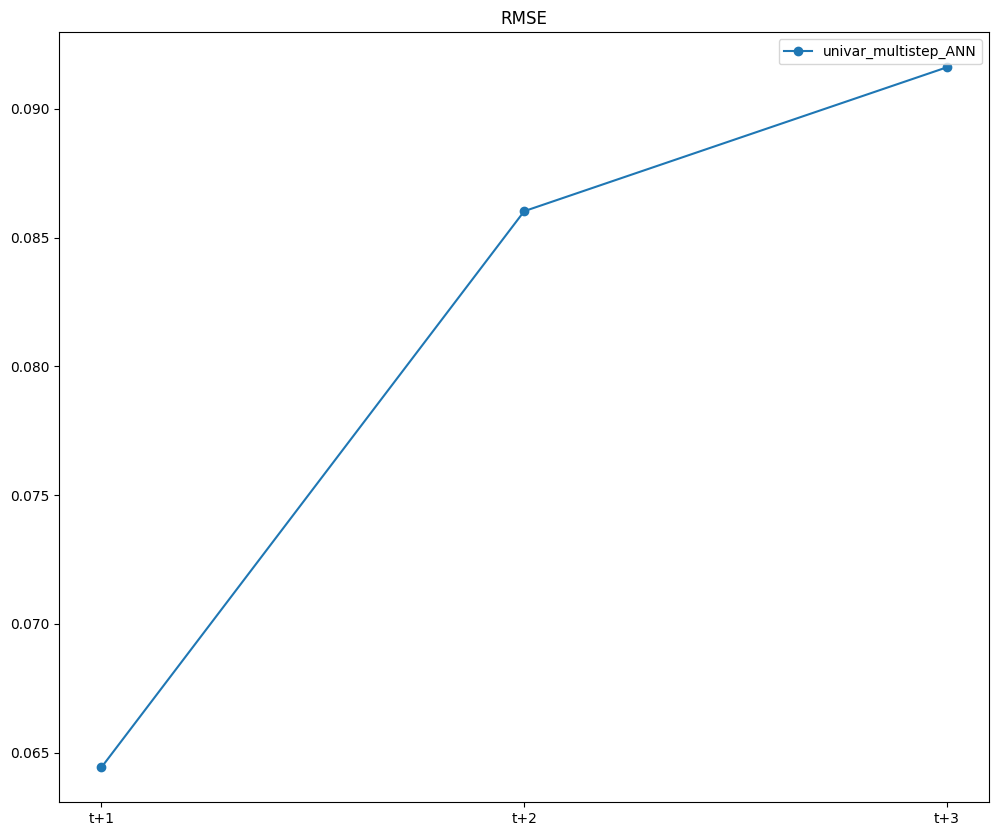

In [ ]:
time_labels = ['t+1', 't+2', 't+3']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = 24  # cuantos puntos del final de la serie seran usados para prueba.Usaremos los ultimos 2 años, los cuales son 24 meses
steps_in = 12  # con cuantos puntos temporales previos se va hacer el forecasting
steps_out = 3  # los modelos predicen 3 puntos temporales futuros
n_neurons = 128   # numero de neuronas de la capa oculta de la ANN
n_epochs = 500   # numero de epocas de entrenamiento 500
n_batch  = 32    # tamaño del minibatch de entrenamiento

# define configuracion:  [steps_in, steps_out, n_neurons, n_epochs, n_batch]
config = [steps_in, steps_out, n_neurons, n_epochs, n_batch]

scaler = MinMaxScaler()
Morosidad_scaled = scaler.fit_transform(df_Lima['Tasa de morosidad (%)'].values.reshape(-1, 1)).flatten()

# Evalua el modelo MLP univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_ANN(Morosidad_scaled, test_size, config)

# imprime score
print('RMSE de univar_multistep_ANN: %.3f ' % (score))
# plotea scores
plt.plot(time_labels, scores, marker='o', label='univar_multistep_ANN')
print()

# show plot
plt.title('RMSE')
plt.legend()
plt.show()

## Modelo ANN Multivariado Multi-step

Ahora evaluaremos modelos ANN incluyendo todas las series como entrada del modelo para realizar la prediccion de la variable  Tasa de morosidad (%).

### Funcion para generar muestras de entrenamiento para forecasting univariado multistep

La funcion <b>split_sequences()</b> genera tuplas de secuencias de entrenamiento multivariadas a partir de las secuencias pasadas. Esta desliza una ventana de step_in puntos temporales de ancho sobre la series (sequences), generando las secuencias multivariadas de entrada (inputs de la red) junto con la secuencia target que son los siguientes steps_out puntos de la primera secuencia (columna 0).

In [29]:
# Funcion para generar secuencias multivariadas de n_steps_in de entrada y steps_out de target a partir de una secuencia multivariada
def split_sequences(sequences, steps_in, steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia
        end_ix = i + steps_in  # final de la muestra de entra
        out_end_ix = end_ix + steps_out  # final de la muestra de salida

        # si el indice es mayor que la secuencia entonces deja de generar mas muestras
        if out_end_ix > len(sequences)-1:
            break

        X.append( sequences[i:end_ix, :] ) # añade las secuencias a la lista de muestras de entrada para entrenamiento
        #target_idx = sequences.shape[1] - 1 
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los siguientes steps_out de secuencia 0 (Tasa de morosidad (%)) como target
    return np.array(X), np.array(y)

Probemos la funcion *split_sequences()*

In [ ]:
steps_in = 12
steps_out = 3

# genera las muestras de entrenamiento en rolling window a partir de la serie de entrenamiento
X, y = split_sequences(df_Lima.values, steps_in, steps_out)
print (X.shape)
print (y.shape)


(146, 12, 7)
(146, 3)


### Funciones para entrenamiento y prediccion de un modelo ANN para forecasting multistep con entrada multivariada

La funcion <b>multivar_multistep_ANN_fit</b> define y entrena un modelo ANN de pronóstico multi-step de la serie 'Tasa de morosidad (%)' con entrada multivariada. Los hiperaparámetros del modelo son pasados en config. Estos son: la cantidad de timesteps de entrada, la cantidad de filtros convolucionales, el tamaño del filtro, el numero de epocas de entrenamiento y el tamaño del minibatch de entrenamiento

In [32]:
# Funcion para entrenar el modelo ANN
def multivar_multistep_ANN_fit(train_series, config):

    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # Crear secuencias multivariadas de entrenamiento
    X, y = split_sequences(train_series, steps_in, steps_out)

    # Aplanar la entrada para el ANN
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))

    # Crear modelo ANN mejorado
    modelo = Sequential()
    modelo.add(Dense(n_neurons,activation='relu', input_dim=n_input))
    modelo.add(BatchNormalization())
    modelo.add(Dropout(0.3))
    modelo.add(Dense(int(n_neurons/2),activation='relu'))

    
    modelo.add(Dropout(0.3))
    modelo.add(Dense(steps_out)) 

    modelo.compile(loss='mse', optimizer="adam", metrics=['mae'])

    # Callbacks
    early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, verbose=1)

    # Entrenamiento con validación automática
    modelo.fit(X, y,
                epochs=n_epochs,
                batch_size=n_batch,
                verbose=0,
                callbacks=[early_stop])

    return modelo


La funcion <b>multivar_multistep_ANN_predict</b> hace el forecasting con un modelo ANN ya ajustado y en base a las series históricas (history_series)

In [31]:
# predice n_steps_out valores siguientes de las serie en history_series con un modelo ANN ya ajustado
def multivar_multistep_ANN_predict(modelo, history_series, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # el numero de series es la 2da dimension de history_series (la 1era es el numero de time_steps)
    n_features = history_series.shape[1]

    # extrae la muestra para enviar al modelo ANN para hacer la prediccion (ultimos steps_in puntos temporales de todas las series historicas)
    X_input = history_series[-steps_in:, :]
    X_input = X_input.reshape(1, steps_in * n_features)     # aplana las secuencias de entrada para el modelo ANN

    # predice
    yhat = modelo.predict(X_input, verbose=0)
    return yhat[0]

### Funcion para evaluar en walk-forward un modelo MLP para forecasting multistep con entradas multivariadas

In [30]:
def evaluate_multivar_multistep_mlp(series, test_size, config):

    # Unpack de hiperparámetros
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # Separar train / test
    train_series = series[:-test_size, :]
    test_series  = series[-test_size:, :]

    # Entrenar el modelo una sola vez
    modelo = multivar_multistep_ANN_fit(train_series, config)
    modelo.save('ANN_multi.keras')

    # Walk-forward: generar predicciones y vectores reales
    history     = train_series.tolist()
    predictions = []
    real        = []
    for i in range(len(test_series) - steps_out + 1):
        # predice multistep a partir de todo el historial
        yhat = multivar_multistep_ANN_predict(modelo, np.array(history), config)
        predictions.append(yhat)
        # sólo Global_active_power (columna 0) como real
        real.append(test_series[i:i+steps_out, 0])
        # añade el siguiente paso al historial
        history.append(test_series[i].tolist())

    predictions = np.array(predictions)  # shape (n_samples, steps_out)
    real        = np.array(real)         # shape (n_samples, steps_out)

    # Métricas de forecasting sobre la serie real vs predicha
    score, scores = evaluate_forecasts(real, predictions)

    # Preparar X_test / y_test para evaluar con Keras
    X_test, y_test = split_sequence(test_series, steps_in, steps_out)
    n_samples, sin, n_features = X_test.shape

    # aplanar X_test para la capa Dense de entrada
    X_test_flat = X_test.reshape((n_samples, sin * n_features))
    # solo la primera variable como target (shape (n_samples, steps_out))
    y_test_flat = y_test[:, :, 0]

    # Evaluación directa con Keras
    loss, mae = modelo.evaluate(
        X_test_flat,
        y_test_flat,
        verbose=0
    )
    print("Metricas de evaluación:")
    print(f"MSE última: {loss:.4f}  —  MAE última: {mae:.4f}")

    return score, scores


### Evalua la calidad de pronostico (3 meses) sobre la serie 'Tasa de morosidad (%)' con modelo  ANN  multistep con entradas multivariadas. Primero se probó con el dataset entero, y luego por partes. Los resultados más exitosos se encontrarón con la variable más correlacionada "Ingreso bruto del hogar" y con la información temporal del mes.

c:\Users\Joaquin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 104: early stopping
Restoring model weights from the end of the best epoch: 84.
Metricas de evaluación:
MSE última: 0.0281  —  MAE última: 0.1370
RMSE de univar_multistep_ANN: 0.164 


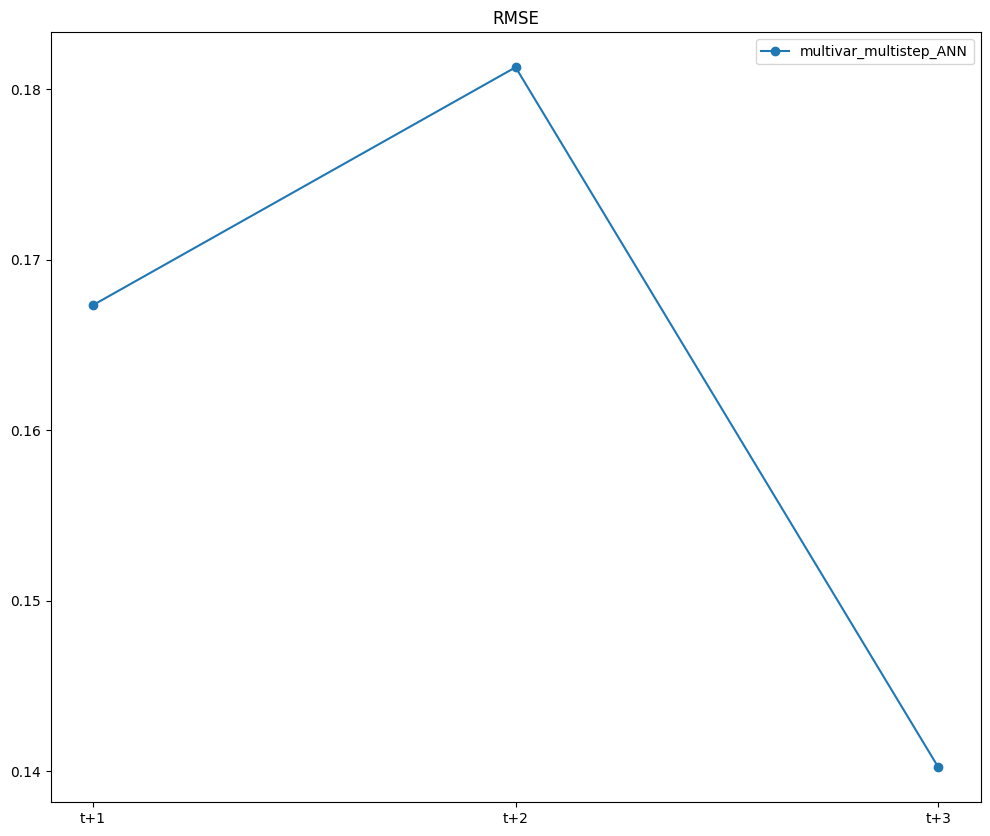

In [33]:
time_labels = ['t+1', 't+2', 't+3']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = 24  # cuantos puntos del final de la serie seran usados para prueba.Usaremos los ultimos 2 años, que son 24 meses
steps_in = 12  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 3  # los modelos predicen 3 puntos temporales futuros
n_neurons = 64    # numero de neuronas de la capa oculta de la ANN
n_epochs = 3000   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# define configuracion:  [steps_in, steps_out, n_neurons, n_epochs, n_batch]
config = [steps_in, steps_out, n_neurons, n_epochs, n_batch]


scaler = MinMaxScaler()
df_Lima.index = pd.to_datetime(df_Lima.index)
df_Lima['mes'] = df_Lima.index.month
features = ['Tasa de morosidad (%)', 'Ingreso bruto del hogar', 'mes']
df_Lima_scaled = scaler.fit_transform(df_Lima[features].values)
df_Lima_scaled = pd.DataFrame(scaler.fit_transform(df_Lima.values), columns=df_Lima.columns, index=df_Lima.index)

# Evalua el modelo MLP multivariado multi-step  en walk-forward
score, scores = evaluate_multivar_multistep_mlp(df_Lima_scaled.values, test_size, config)

# imprime score
print('RMSE de univar_multistep_ANN: %.3f ' % (score))

# plotea scores
plt.plot(time_labels, scores, marker='o', label='multivar_multistep_ANN')

# show plot
plt.title('RMSE')
plt.legend()
plt.show()

Tras el exhaustivo análisis, se comprobó que con el modelo ANN univariado se encontraron los resultados más efectivos. Con RMSE y MAE muy bajos, se demuestra que es capaz de encontrar un modelo efectivo. Por otro lado, el dataset no afecto al modelo de la forma esperada. Si bien se supero al modelo de persistencia con facilidad, empeoró en relación al modelo univariado. Los puntos de mejora vienen de encontrar un dataset más completo o extenso, debido a la poca cantidad de puntos temporales disponibles, por medio de una inversión para acceder a mejores datasets; y de la implementación de modelos espec+ificos ára predicción como LSTM o GRU. En este trabajo no se utilizaron ya que al tener pocos datos disponibles, modelos muy potentes hacen un overfitting uy rápido y no funcionan de buena manera.